# Multi Agent Collaboration and Competition Project

---

I wanted to do this whole thing on my own computer.  However, I'm still struggling to get the Unity ML-Agents environments to work properly.  Because I'm on a time schedule, I need to bang out the project.  So I'm using the Udacity Workspace to do this project.  It sucks, but I'm working to resolve all of this.  

I'm using my last project, the DDPG_Project, as the foundation of this project and building from there.

### 1. Start the Environment

We need to install a bunch of packages.  Run the next two code cells to do the install.  This line will take a few minutes to run and will only work in the Udacity Workspace.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
import random
import torch
import workspace_utils
from ma_ddpg_agent import Agent
from collections import deque
from unityagents import UnityEnvironment
from workspace_utils import active_session
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now we need to install the environment.  Because I am in the Udacity Workspace, the environment already exists.  All I need to do it tap into it via the proper file path.  

In [3]:
env = UnityEnvironment(file_name='/data/Tennis_Linux_NoVis/Tennis')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.

- This yields a single score for each episode.

The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you can see how to use the Python API to control the agent and receive feedback from the environment.

Because I'm in the Udacity Workspace, you will not be able to watch the Agents while they are training.  Suck ... I know.

This code takes random Actions, so it's performance will be less than stellar.  However, it should prove that everything is set up properly and working as expected.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. Now to train the Agent

A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- **_After training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

But first, we get the actions for each of the two Agents and combine them into a single array

In [7]:
def get_actions(states, add_noise):
    action_0 = agent_0.act(states, add_noise)
    action_1 = agent_1.act(states, add_noise)
    action_jackson = np.concatenate((action_0, action_1), axis=0).flatten()
    
    return action_jackson

We start with the Deep Deterministic Policy Gradient (DDPG) function.

In [8]:
def ma_ddpg(n_episodes=5000, train_mode=True):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes            : maximum number of training episodes
        train_mode            : if 'True' set environment to training mode

    """

    scored = []
    mov_avg = []                                                    # list containing the moving averages
    mean_scores = []
    mean_score = 0.0
    solved = False
    scores_window = deque(maxlen=100)                              # last 100 scores

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]    # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48))  # get the current state (for each agent) and combine
        scores = np.zeros(num_agents)                              # initialize the score (for each agent)
        agent_0.reset()
        agent_1.reset()
        
        while True:                                                # run the entire match, not just 1000 timesteps
            actions = get_actions(states, add_noise=True)          # select a new action (for each agent)
            env_info = env.step(actions)[brain_name]               # send all actions to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # get next new state (for each agent)
            rewards = env_info.rewards                             # get new reward (for each agent)
            dones = env_info.local_done                             # see if episode finished
            
            agent_0.step(states, actions, rewards[0], next_states, dones, 0) # agent 1 learns here
            agent_1.step(states, actions, rewards[1], next_states, dones, 1) # agent 2 learns here
            
            scores += np.max(rewards)                              # update the new score (for each agent)
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                       # exit loop if episode finished
                break

        scores_window.append(scores)                            # save the most recent new score
        average = np.mean(scores_window)                        # calculate the average
        if solved==False:
            scored.append(scores)                               # save the most recent new score to the total
            mov_avg.append(average)                             # save the most recent moving average
                
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)), end="")
            
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)))
        if (np.mean(scores_window) >= 0.5) & (solved==False):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'
                    .format(i_episode, np.mean(scores_window)))
            solved = True
        
        if (np.mean(scores_window) >= 0.5) & (solved==True):
            print('\nEnvironment solved with BUFFER in {:d} episodes!\tAverage Score: {:.2f}'
                    .format(i_episode, np.mean(scores_window)))  # to ensure that my final plot stays > 30
        
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')   # save the actor weights
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth') # save the critic weights
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')   # save the actor weights
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth') # save the critic weights
            
            break
        
    return scored, mov_avg

Now we initialize the Agents and run the ma_ddpg function and see how well we learn ...

In [9]:
agent_0 = Agent(state_size, action_size, random_seed=0, num_agents=1)
agent_1 = Agent(state_size, action_size, random_seed=0, num_agents=1)
with active_session():
    scores, avgs = ma_ddpg()

Episode 10	Average Score: 0.000
Episode 20	Average Score: 0.000
Episode 30	Average Score: 0.003
Episode 40	Average Score: 0.010
Episode 50	Average Score: 0.008
Episode 60	Average Score: 0.008
Episode 70	Average Score: 0.010
Episode 80	Average Score: 0.010
Episode 90	Average Score: 0.019
Episode 100	Average Score: 0.019
Episode 110	Average Score: 0.023
Episode 120	Average Score: 0.037
Episode 130	Average Score: 0.040
Episode 140	Average Score: 0.044
Episode 150	Average Score: 0.048
Episode 160	Average Score: 0.051
Episode 170	Average Score: 0.057
Episode 180	Average Score: 0.062
Episode 190	Average Score: 0.061
Episode 200	Average Score: 0.068
Episode 210	Average Score: 0.069
Episode 220	Average Score: 0.058
Episode 230	Average Score: 0.064
Episode 240	Average Score: 0.062
Episode 250	Average Score: 0.062
Episode 260	Average Score: 0.072
Episode 270	Average Score: 0.079
Episode 280	Average Score: 0.082
Episode 290	Average Score: 0.082
Episode 300	Average Score: 0.086
Episode 310	Average

### 4. Now Let's Plot Our Results From Training

There are two lines in the plot below.  The Blue line shows what the scores where during training.  The Yellow line shows the average score over 100 episodes.

We are considered "trained" when we can average a score of 0.5 for every Agent over 100 episodes.  And that happened at episode 1581.

This time I didn't bother to train a little bit longer in an attempt to ensure that my saved weights will give me a good chance of getting a score of 0.5 or better in the future.  I had a REALLY hard time getting to 0.5, and it took a LONG time.  So I'm going to take my win and move on.

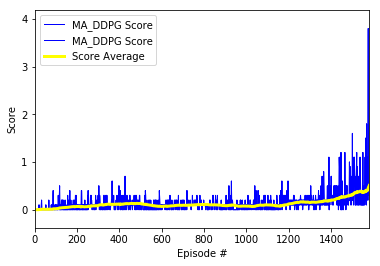

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, c='blue', linewidth=1, label="MA_DDPG Score")
plt.plot(np.arange(len(scores)), avgs, c='yellow', linewidth=3, label="Score Average")
plt.legend(loc='upper left')
plt.margins(x=0.0, y=0.1)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Now that we are finished, we can close the environment.

In [11]:
env.close()